# Installation and Imports

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import ast
import json
import os
import warnings
warnings.filterwarnings('ignore')


# Evaluate Agreement

Average = weighted

Precision = 0.743
Recall = 0.744
F1 = 0.739
              precision    recall  f1-score   support

         FUN       0.80      0.79      0.79       412
         STR       0.79      0.82      0.80       535
         MIX       0.60      0.40      0.48       176
         OTH       0.50      0.73      0.60        77

    accuracy                           0.74      1200
   macro avg       0.67      0.69      0.67      1200
weighted avg       0.74      0.74      0.74      1200



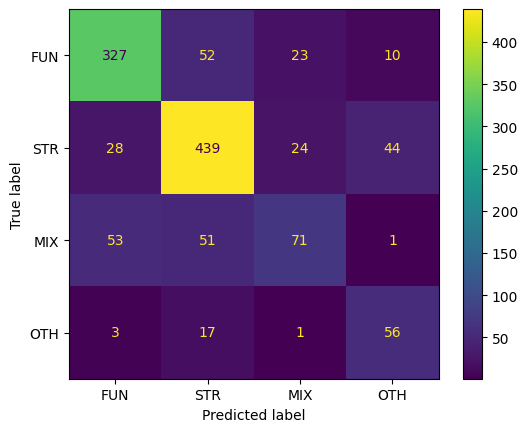

In [2]:
# Import Agreement Data
aggreement_df = pd.read_excel('/home/fantoni/patent-sentence-classification/data/1200_agreement_All.xlsx')

# Set labels
dispaly_labels = ['FUN', 'STR', 'MIX', 'OTH']
true_labels = aggreement_df['sent_tag_mc']  
predicted_labels = aggreement_df['sent_tag_ml']

# Calculate metrics
average='weighted'
precision = precision_score(true_labels, predicted_labels, average=average, zero_division=0)
recall = recall_score(true_labels, predicted_labels, average=average, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average=average, zero_division=0)

print(f'Average = {average}\n')
print(f'Precision = {precision:.3f}')  
print(f'Recall = {recall:.3f}')  
print(f'F1 = {f1:.3f}') 

# Create Classification Report
class_report = classification_report(true_labels, predicted_labels, labels=dispaly_labels, target_names=dispaly_labels, zero_division=0)
print (class_report)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=dispaly_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dispaly_labels)
disp.plot()
plt.show()

# Evaluate Results

Average = macro

Precision = 0.557
Recall = 0.604
F1 = 0.476
              precision    recall  f1-score   support

         FUN       0.83      0.43      0.56       412
         STR       0.89      0.49      0.63       535
         MIX       0.33      0.51      0.40       176
         OTH       0.18      0.99      0.30        77

    accuracy                           0.50      1200
   macro avg       0.56      0.60      0.48      1200
weighted avg       0.74      0.50      0.55      1200



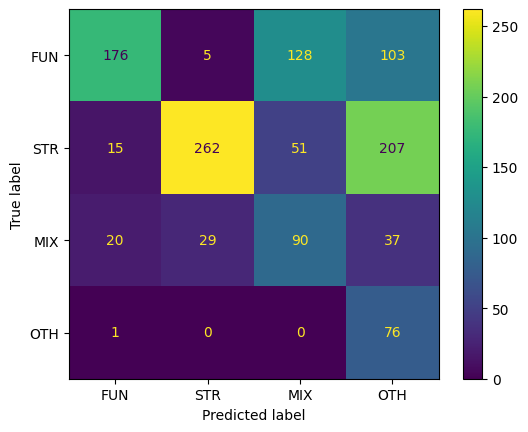

In [5]:
# Import data
#result_df = pd.read_excel("/home/fantoni/patent-sentence-classification/results/finetuning/bert-large-uncased-test-10-7.xlsx")
#result_df = pd.read_excel("/home/fantoni/patent-sentence-classification/results/finetuning/bert-for-patents-test-10-7.xlsx")
#result_df = pd.read_excel("/home/fantoni/patent-sentence-classification/results/finetuning/bert-for-patents_test_10_7.xlsx")
#result_df = pd.read_excel('/home/fantoni/patent-sentence-classification/results/prompting/gpt-3.5-turbo_prompt_3.xlsx')
result_df = pd.read_excel('/home/fantoni/patent-sentence-classification/results/prompting/gpt-4o_prompt_8.xlsx')
#result_df = pd.read_excel("/home/fantoni/patent-sentence-classification/results/incremental/test_10_3.xlsx")

# Set labels
dispaly_labels = ['FUN', 'STR', 'MIX', 'OTH']
true_labels = result_df['sent_tag']  
predicted_labels = result_df['predicted_tag']

# Calculate metrics
average='macro'
precision = precision_score(true_labels, predicted_labels, average=average, zero_division=0)
recall = recall_score(true_labels, predicted_labels, average=average, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average=average, zero_division=0)
print(f'Average = {average}\n')
print(f'Precision = {precision:.3f}')  
print(f'Recall = {recall:.3f}')  
print(f'F1 = {f1:.3f}') 

# Create Classification Report
class_report = classification_report(true_labels, predicted_labels, labels=dispaly_labels, target_names=dispaly_labels, zero_division=0)
print (class_report)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=dispaly_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dispaly_labels)
disp.plot()
plt.show()

# Evaluate Results 10-Folds

In [35]:
folder_path = "/home/fantoni/patent-sentence-classification/results/incremental"
id2num = {'1': 480, '2': 960, '3': 1440, '4': 1920, '5': 2400, '6': 2880, '7': 3360, '8': 3840, '9': 4320, '10': 4800}

# Set averaging mode
average = 'weighted'

results_all = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(".xlsx"):
        sample_id = file_name.split('_')[1]
        if sample_id == '10': # # Only process files with sample_id '10'
            df = pd.read_excel(os.path.join(folder_path, file_name))
            true_labels = df['sent_tag']  
            predicted_labels = df['predicted_tag']

            metrics = {
                'Sample Size': id2num[sample_id],
                'Precision': round(precision_score(true_labels, predicted_labels, average=average, zero_division=0), 3),
                'Recall': round(recall_score(true_labels, predicted_labels, average=average, zero_division=0), 3),
                'F1-Score': round(f1_score(true_labels, predicted_labels, average=average, zero_division=0), 3)
            }
            results_all.append(metrics)

results_df = pd.DataFrame(results_all).sort_values(by='Sample Size')
results_df

,Sample Size,Precision,Recall,F1-Score
0,4800,0.719,0.746,0.713
1,4800,0.753,0.760,0.735
2,4800,0.742,0.748,0.702
3,4800,0.725,0.758,0.709
4,4800,0.736,0.747,0.697
5,4800,0.754,0.757,0.719
6,4800,0.757,0.762,0.735
7,4800,0.759,0.765,0.744
8,4800,0.737,0.753,0.712
9,4800,0.756,0.759,0.716


In [36]:
# Compute mean values for each sample size
mean_results_df = results_df.groupby("Sample Size").mean().reset_index()
mean_results_df.columns = ["Sample Size", "Mean Precision", "Mean Recall", "Mean F1-Score"]
mean_results_df = mean_results_df.round(3)
mean_results_df

,Sample Size,Mean Precision,Mean Recall,Mean F1-Score
0,4800,0.744,0.756,0.718


# Evaluate Time

In [15]:
# Time Analysis for prompting models
if 'elapsed_time_sec' in result_df.columns:
    avg_time_per_sent = result_df['elapsed_time_sec'].sum()/len(result_df)
    total_time = result_df['elapsed_time_sec'].sum()
    print(f"Mean Inference Time per Sentence = {avg_time_per_sent:.2f}")
    print(f"Total Inference Time = {total_time:.2f} seconds")
    print(f"Total Inference Time = {total_time/60:.2f} min")

Mean Inference Time per Sentence = 0.62
Total Inference Time = 745.18 seconds
Total Inference Time = 12.42 min


# Evaluate Cost
To calculate cost: https://openai.com/api/pricing/


In [6]:
# Define all pricing combinations
pricing_combinations = [
    {"input_price": 2.50/1000000, "output_price": 10/1000000, "model": "gpt-4o"},
    {"input_price": 3/1000000, "output_price": 6/1000000, "model": "gpt-3.5-turbo"},
    {"input_price": 0.5/1000000, "output_price": 1.5/1000000, "model": "gpt-3.5-turbo-0125"}
]

# Iterate through each pricing combination
for pricing in pricing_combinations:
    input_price = pricing["input_price"]
    output_price = pricing["output_price"]
    model = pricing["model"]

    input_cost = result_df['input_count'].sum() * input_price
    output_cost = result_df['output_count'].sum() * output_price
    total_cost = round(input_cost + output_cost, 3)
    print(f"Total cost for {len(result_df)} sentences using '{model}' = {total_cost:.2f}$")

Total cost for 1200 sentences using 'gpt-4o' = 1.10$
Total cost for 1200 sentences using 'gpt-3.5-turbo' = 1.31$
Total cost for 1200 sentences using 'gpt-3.5-turbo-0125' = 0.22$


In [ ]:
# Simulate Cost of a Prompt

# Set parameters
input_tokens = 200
output_tokens = 3
n_sentence = 600

# Define all pricing combinations
pricing_combinations = [
    {"input_price": 2.50/1000000, "output_price": 10/1000000, "model": "gpt-4o"},
    {"input_price": 3/1000000, "output_price": 6/1000000, "model": "gpt-3.5-turbo"},
    {"input_price": 0.5/1000000, "output_price": 1.5/1000000, "model": "gpt-3.5-turbo-0125"}
]

# Iterate through each pricing combination
for pricing in pricing_combinations:
    input_price = pricing["input_price"]
    output_price = pricing["output_price"]
    model = pricing["model"]
    
    # Calculate cost per sentence for the given model
    input_cost = input_tokens * input_price
    output_cost = output_tokens * output_price
    total_cost_per_sentence = input_cost + output_cost
    total_cost_for_n_sentences = total_cost_per_sentence * n_sentence
    
    # Print the results
    print(f"Model: {model}")
    print(f"  Cost Prompt: {input_cost:.5f}$")
    print(f"  Cost Output: {output_cost:.5f}$")
    print(f"  Total Cost per Sentence: {total_cost_per_sentence:.5f}$")
    print(f"  Total Cost for {n_sentence} Sentences: {total_cost_for_n_sentences:.2f}$\n")

Model: gpt-4o
  Cost Prompt: 0.00050$
  Cost Output: 0.00003$
  Total Cost per Sentence: 0.00053$
  Total Cost for 600 Sentences: 0.32$

Model: gpt-3.5-turbo
  Cost Prompt: 0.00060$
  Cost Output: 0.00002$
  Total Cost per Sentence: 0.00062$
  Total Cost for 600 Sentences: 0.37$

Model: gpt-3.5-turbo-0125
  Cost Prompt: 0.00010$
  Cost Output: 0.00000$
  Total Cost per Sentence: 0.00010$
  Total Cost for 600 Sentences: 0.06$



 # Confidence Cut-Off Analysis

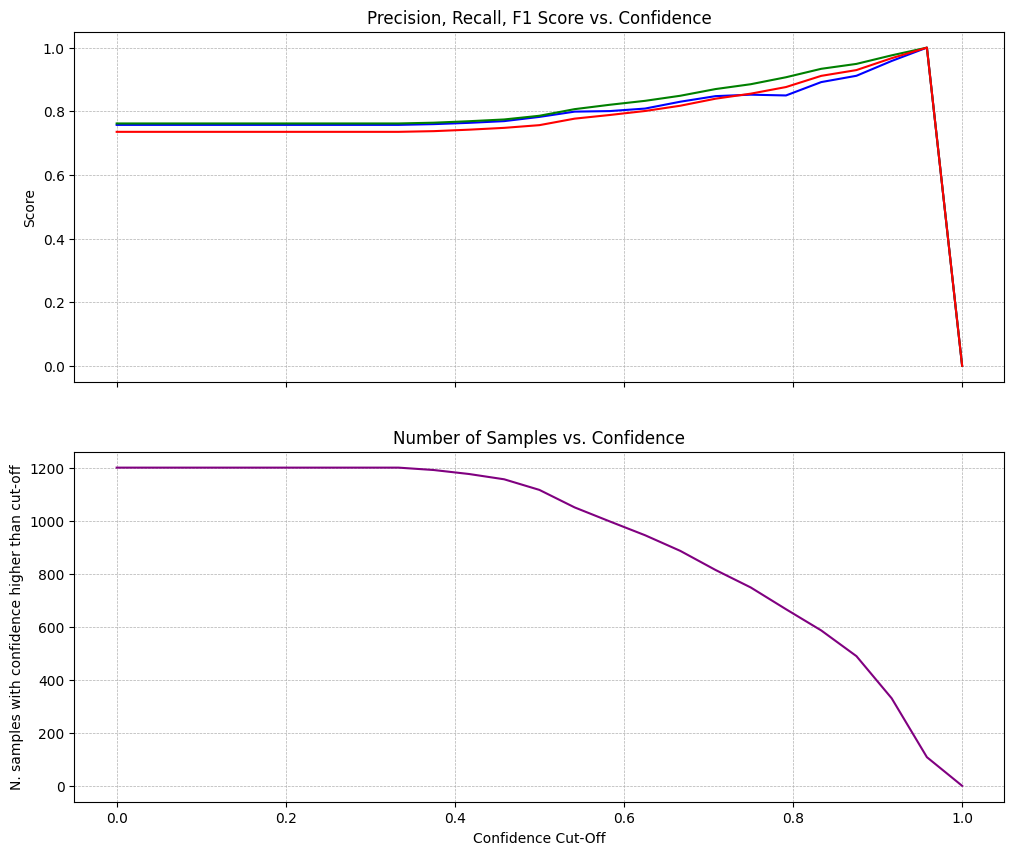

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Extract the maximum probability per row
result_df["probabilities"] = result_df["probabilities"].apply(ast.literal_eval) # import as a list
result_df['max_prob'] = result_df['probabilities'].apply(max)

# Define threshold range
thresholds = np.linspace(0, 1, 25)  # 10 steps from 0 to 0.90

# Initialize lists to store precision, recall, f1-score, and support values
precision_values = []
recall_values = []
f1_values = []
count_values = []

# Compute metrics for each threshold
for threshold in thresholds:
    # Filter based on threshold
    selected = result_df[result_df['max_prob'] >= threshold]    
    if selected.empty:
        precision_values.append(0)
        recall_values.append(0)
        f1_values.append(0)
        count_values.append(0)
    else:
        # Compute precision, recall, f1-score
        count = len(selected)
        precision, recall, f1, _ = precision_recall_fscore_support(selected['sent_class'], selected['predicted_class'], average=average, zero_division=0)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)
        count_values.append(count)

# Create figure and axes
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot precision, recall, F1-score
ax[0].plot(thresholds, precision_values, label="Precision", color='blue')
ax[0].plot(thresholds, recall_values, label="Recall", color='green')
ax[0].plot(thresholds, f1_values, label="F1 Score", color='red')
ax[0].set_ylabel("Score")
ax[0].set_title("Precision, Recall, F1 Score vs. Confidence")
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot count values
ax[1].plot(thresholds, count_values, label="Count", color='purple')
ax[1].set_xlabel("Confidence Cut-Off")
ax[1].set_ylabel("N. samples with confidence higher than cut-off")
ax[1].set_title("Number of Samples vs. Confidence")
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

# Agreement Analysis

In [3]:
# Import agreement data
agreement_df = pd.read_excel("/home/fantoni/patent-sentence-classification/data/1200_agreement_All.xlsx", usecols=['sent_id', 'agreement', 'sent_tag_ml'])

# Merge result with agreeement data
result_df = pd.merge(result_df, agreement_df, on='sent_id', how='left')

# Indetify Correct Prediction
result_df['correct'] = result_df['sent_class'] == result_df['predicted_class']

result_df

NameError: name 'result_df' is not defined

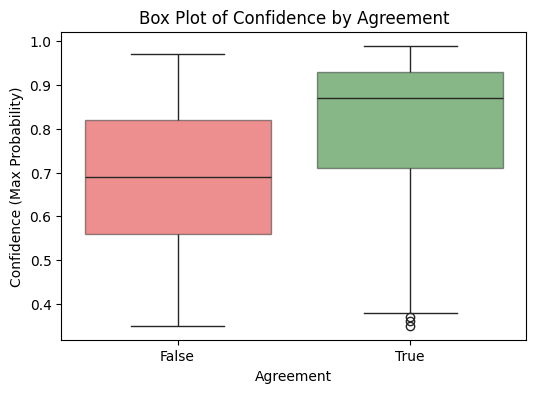

True Agreement: 'statistic': 0.8732367407647821, 'p_value': 2.6572736564122316e-26
False Agreement: 'statistic': 0.9629077114468297, 'p_value': 4.6521958419152384e-07
Mann-Whitney U Test: U-Statistic = 197962.0, p-value = 2.9610402501912384e-31
Kolmogorov-Smirnov Test: KS-Statistic = 0.3498145182764243, p-value = 2.2840920181752387e-25


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ks_2samp, mannwhitneyu

plt.figure(figsize=(6, 4))
sns.boxplot(data=result_df, x='agreement', y='max_prob', palette={'True': 'green', 'False': 'red'}, boxprops=dict(alpha=0.5))
plt.xlabel("Agreement")
plt.ylabel("Confidence (Max Probability)")
plt.title("Box Plot of Confidence by Agreement")
plt.show()

# Shapiro-Wilk Test (tests normality)
true_agree = result_df[result_df['agreement']==True]['max_prob'].dropna()
false_agree = result_df[result_df['agreement']==False]['max_prob'].dropna()
shapiro_true = shapiro(true_agree)
shapiro_false = shapiro(false_agree)
print(f"True Agreement: 'statistic': {shapiro_true.statistic}, 'p_value': {shapiro_true.pvalue}")
print(f"False Agreement: 'statistic': {shapiro_false.statistic}, 'p_value': {shapiro_false.pvalue}")

# Perform the Mann-Whitney U Test
# If p-value ≤ 0.05, the two distributions are significantly different in terms of their medians.
mann_whitney = mannwhitneyu(true_agree, false_agree, alternative='two-sided')

# Perform the Kolmogorov-Smirnov Test
#If p-value ≤ 0.05, the two distributions are significantly different in shape.
ks_test = ks_2samp(true_agree, false_agree)

# Print Results
print(f"Mann-Whitney U Test: U-Statistic = {mann_whitney.statistic}, p-value = {mann_whitney.pvalue}")
print(f"Kolmogorov-Smirnov Test: KS-Statistic = {ks_test.statistic}, p-value = {ks_test.pvalue}")

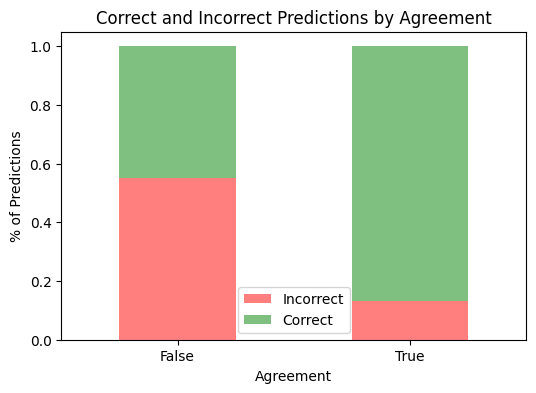

In [ ]:
# Compute proportions for stacked bar chart
groups = result_df.groupby(['agreement', 'correct']).size().unstack()
proportions = groups.div(groups.sum(axis=1), axis=0)

# Plot stacked bar chart
proportions.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(6, 4), alpha=0.5)
plt.xlabel("Agreement")
plt.ylabel(f"% of Predictions")
plt.title("Correct and Incorrect Predictions by Agreement")
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0)
plt.legend(['Incorrect', 'Correct'])
plt.show()

# Create Comparison Table

In [4]:
import pandas as pd
import json
import os
from src.utils import compute_metrics_for_label

# Import prompt templates to print them in the result table
with open("./prompting/prompt_templates.json", "r") as file:
        templates = json.load(file)

# Define file paths to results
file_paths = [
    '/home/fantoni/patent-sentence-classification/results/finetuning/bert-for-patents-train-10-4.xlsx',
    '/home/fantoni/patent-sentence-classification/results/finetuning/bert-large-uncased-train-10-4.xlsx',
    '/home/fantoni/patent-sentence-classification/results/prompting/gpt-3.5-turbo_prompt_3.xlsx',
    '/home/fantoni/patent-sentence-classification/results/prompting/gpt-4o_prompt_3.xlsx',
    '/home/fantoni/patent-sentence-classification/results/prompting/Llama-3.1-8B-Instruct_prompt_3.xlsx'
]

data = []

# Compute metrics for models
for file_path in file_paths:
    file_name = os.path.splitext(os.path.basename(file_path))[0]  # Extract filename
    file_name_components = file_name.replace('.xlsx', '').split('_')
    model_name = file_name_components[0]

    # 0. Import Data
    result_df = pd.read_excel(file_path)

    # 1. Compute metrics
    true_labels = result_df['sent_tag']  
    pred_lablels = result_df['predicted_tag']    
    p_all, r_all, f1_all = compute_metrics_for_label(true_labels, pred_lablels, label='All', average='weighted')
    p_FUN, r_FUN, f1_FUN = compute_metrics_for_label(true_labels, pred_lablels, label='FUN', average='weighted')
    p_STR, r_STR, f1_STR = compute_metrics_for_label(true_labels, pred_lablels, label='STR', average='weighted')
    p_MIX, r_MIX, f1_MIX = compute_metrics_for_label(true_labels, pred_lablels, label='MIX', average='weighted')
    p_OTH, r_OTH, f1_OTH = compute_metrics_for_label(true_labels, pred_lablels, label='OTH', average='weighted')

    # 2. Calculate Time
    if 'elapsed_time_sec' in result_df.columns:
        training_time = None
        inference_time = round(result_df['elapsed_time_sec'].sum(), 2)
        prompt_id = file_name_components[-1]
        prompt_name = prompt_name = "_".join(file_name_components[1:])
        prompt_text = templates[prompt_name]
    else:
        training_time = None
        inference_time = None
        prompt_id = '-'
        prompt_text = '-'

    # 3. Calculate Cost for ChatGPT models
    if model_name in ['gpt-3.5-turbo', 'gpt-4o']:
            
        # Define pricing combinations
        pricing = {
            "gpt-4o": {"input_price": 2.50/1000000, "output_price": 10/1000000},
            "gpt-3.5-turbo": {"input_price": 0.5/1000000, "output_price": 1.5/1000000}
        }

        input_price = pricing[model_name]["input_price"]
        output_price = pricing[model_name]["output_price"]
        input_cost = result_df['input_count'].sum() * input_price
        output_cost = result_df['output_count'].sum() * output_price
        total_cost = round(input_cost + output_cost, 3)
    
    else:
        total_cost = None
    
    # Append results to data list
    data.append({
        "model": model_name,
        "prompt_id": prompt_id,
        "prompt_text": prompt_text,
        "precision_All": p_all,
        "recall_All": r_all,
        "f1_All": f1_all,
        "precision_FUN": p_FUN,
        "recall_FUN": r_FUN,
        "f1_FUN": f1_FUN,
        "precision_STR": p_STR,
        "recall_STR": r_STR,
        "f1_STR": f1_STR,
        "precision_MIX": p_MIX,
        "recall_MIX": r_MIX,
        "f1_MIX": f1_MIX,
        "precision_OTH": p_OTH,
        "recall_OTH": r_OTH,
        "f1_OTH": f1_OTH,
        "training_time": training_time,
        "inference_time": inference_time,
        "total_cost": total_cost
    })

# Compute Agreement
'''
agreement_df = pd.read_excel('/home/fantoni/patent-sentence-classification/data/1200_agreement_All.xlsx')
true_labels = agreement_df['sent_tag_mc']  
pred_lablels = agreement_df['sent_tag_ml']
p_all, r_all, f1_all = compute_metrics_for_label(true_labels, pred_lablels, label='All', average='weighted')
p_FUN, r_FUN, f1_FUN = compute_metrics_for_label(true_labels, pred_lablels, label='FUN', average='weighted')
p_STR, r_STR, f1_STR = compute_metrics_for_label(true_labels, pred_lablels, label='STR', average='weighted')
p_MIX, r_MIX, f1_MIX = compute_metrics_for_label(true_labels, pred_lablels, label='MIX', average='weighted')
p_OTH, r_OTH, f1_OTH = compute_metrics_for_label(true_labels, pred_lablels, label='OTH', average='weighted')

# Append results to data list
data.append({
    "model": 'human',
    "prompt_id": '-',
    "prompt_text": '-',
    "precision_All": p_all,
    "recall_All": r_all,
    "f1_All": f1_all,
    "precision_FUN": p_FUN,
    "recall_FUN": r_FUN,
    "f1_FUN": f1_FUN,
    "precision_STR": p_STR,
    "recall_STR": r_STR,
    "f1_STR": f1_STR,
    "precision_MIX": p_MIX,
    "recall_MIX": r_MIX,
    "f1_MIX": f1_MIX,
    "precision_OTH": p_OTH,
    "recall_OTH": r_OTH,
    "f1_OTH": f1_OTH,
    "training_time": None,
    "inference_time": None,
    "total_cost": None
})
'''

df_results = pd.DataFrame(data)

# Select columns to format as strings with 3 decimals 
format_cols = [
    'precision_All', 'recall_All', 'f1_All',
    'precision_FUN', 'recall_FUN', 'f1_FUN',
    'precision_STR', 'recall_STR', 'f1_STR',
    'precision_MIX', 'recall_MIX', 'f1_MIX',
    'precision_OTH', 'recall_OTH', 'f1_OTH'
]
df_results[format_cols] = df_results[format_cols].map(lambda x: f"{x:.3f}" if pd.notnull(x) else '-')

df_results.to_excel('/home/fantoni/patent-sentence-classification/results/tables/class_comparison.xlsx', index=False)
df_results

,model,prompt_id,prompt_text,precision_All,recall_All,f1_All,precision_FUN,recall_FUN,f1_FUN,precision_STR,...,f1_STR,precision_MIX,recall_MIX,f1_MIX,precision_OTH,recall_OTH,f1_OTH,training_time,inference_time,total_cost
0,bert-for-patents-train-10-4,-,-,0.772,0.777,0.760,0.759,0.850,0.802,0.796,...,0.839,0.708,0.290,0.411,0.814,0.740,0.776,None,NaN,NaN
1,bert-large-uncased-train-10-4,-,-,0.732,0.744,0.700,0.697,0.881,0.778,0.781,...,0.827,0.619,0.074,0.132,0.839,0.610,0.707,None,NaN,NaN
2,gpt-3.5-turbo,3,The functioning of a system refers to the func...,0.712,0.562,0.590,0.716,0.459,0.559,0.885,...,0.675,0.285,0.795,0.419,0.465,0.688,0.555,None,592.21,0.123
3,gpt-4o,3,The functioning of a system refers to the func...,0.689,0.624,0.637,0.798,0.490,0.608,0.778,...,0.773,0.312,0.438,0.364,0.343,0.766,0.474,None,745.18,0.616
4,Llama-3.1-8B-Instruct,3,The functioning of a system refers to the func...,0.618,0.434,0.460,0.760,0.238,0.362,0.702,...,0.649,0.235,0.182,0.205,0.143,0.883,0.246,None,455.74,NaN


# Create Agreement Table

In [6]:
df_agree = pd.read_excel("/home/fantoni/patent-sentence-classification/data/1200_agreement_All.xlsx", usecols=['sent_id', 'sent', 'sent_tag_mc', 'sent_tag_ml', 'agreement', ])
df_gpt = pd.read_excel("/home/fantoni/patent-sentence-classification/results/prompting/gpt-4o_prompt_3.xlsx", usecols=['sent_id', 'predicted_tag'])
df_bert = pd.read_excel("/home/fantoni/patent-sentence-classification/results/finetuning/bert-for-patents-train-10-4.xlsx", usecols=['sent_id', 'probabilities', 'predicted_tag']) 

df_bert = df_bert.rename(columns={'predicted_tag':  'predicted_tag_bert'}) 
df_gpt = df_gpt.rename(columns={'predicted_tag':  'predicted_tag_gpt'}) 

df = pd.merge(df_agree, df_gpt, how='inner', on='sent_id')
df = pd.merge(df, df_bert, how='inner', on='sent_id')

df['correct_gpt'] = df['sent_tag_mc'] == df['predicted_tag_gpt']
df['correct_bert'] = df['sent_tag_mc'] == df['predicted_tag_bert']

# Replace True/False with 'yes'/'no' in the relevant columns
df[['agreement', 'correct_gpt', 'correct_bert']] = df[['agreement', 'correct_gpt', 'correct_bert']].replace({True: 'yes', False: 'no'})

df.to_excel('/home/fantoni/patent-sentence-classification/results/tables/class_agreement_all.xlsx', index=False)

In [8]:
# Get example for each Case 

df_case1 = df.query("agreement=='yes' & correct_bert=='yes' & correct_gpt=='yes'")
df_case2 = df.query("agreement=='yes' & correct_bert=='yes' & correct_gpt=='no' & predicted_tag_gpt=='STR'" )
df_case3 = df.query("agreement=='yes' & correct_bert=='no' & correct_gpt=='yes'")
df_case4 = df.query("agreement=='yes' & correct_bert=='no' & correct_gpt=='no'")

df_case5 = df.query("agreement=='no' & correct_bert=='yes' & correct_gpt=='yes'")
df_case6 = df.query("agreement=='no' & correct_bert=='yes' & correct_gpt=='no'")
df_case7 = df.query("agreement=='no' & correct_bert=='no' & correct_gpt=='yes'")
df_case8 = df.query("agreement=='no' & correct_bert=='no' & correct_gpt=='no'")

df_case5

,sent_id,sent,sent_tag_mc,sent_tag_ml,agreement,predicted_tag_gpt,predicted_tag_bert,probabilities,correct_gpt,correct_bert
2,91234,The above-described steps can be implemented u...,FUN,OTH,no,FUN,FUN,"[0.54, 0.16, 0.08, 0.21]",yes,yes
22,181157,"In some cases, the lead can be implanted in th...",FUN,MIX,no,FUN,FUN,"[0.84, 0.04, 0.12, 0.0]",yes,yes
29,1583387,"numbers 5,743,902, 5,957,915, and 6,328,733, t...",OTH,STR,no,OTH,OTH,"[0.01, 0.03, 0.01, 0.95]",yes,yes
43,164989,figure 4A is an exploded assembly view of the ...,STR,OTH,no,STR,STR,"[0.01, 0.85, 0.01, 0.13]",yes,yes
45,1574745,The electrodes in figures 5C and 5D are smalle...,STR,OTH,no,STR,STR,"[0.0, 0.99, 0.0, 0.01]",yes,yes
...,...,...,...,...,...,...,...,...,...,...
1131,1222850,"In other words, even though the system incorpo...",OTH,MIX,no,OTH,OTH,"[0.04, 0.17, 0.02, 0.77]",yes,yes
1151,2591990,The method additionally includes: adaptively a...,FUN,MIX,no,FUN,FUN,"[0.87, 0.01, 0.12, 0.0]",yes,yes
1157,2822983,"As discussed before, an iteration (or recursio...",FUN,STR,no,FUN,FUN,"[0.89, 0.07, 0.02, 0.02]",yes,yes
1188,2595083,Networked lighting systems that utilize Power ...,STR,OTH,no,STR,STR,"[0.02, 0.91, 0.04, 0.02]",yes,yes


In [ ]:
# Group by 'agreement', 'correct_bert', and 'correct_gpt', then count
grouped = df.groupby(['agreement', 'correct_bert', 'correct_gpt']).size().reset_index(name='count')
grouped['percentage'] = (grouped['count'] / len(df)) * 100  # Keep as float for now

# Sort the DataFrame
grouped_df = grouped.sort_values(by=['agreement', 'correct_bert', 'correct_gpt'], ascending=False)

# Create total row as DataFrame
total_row = pd.DataFrame([{
    'agreement': 'Total',
    'correct_bert': '-',
    'correct_gpt': '-',
    'count': grouped['count'].sum(),
    'percentage': grouped['percentage'].sum()
}])

# Concatenate the total row
grouped_df = pd.concat([grouped_df, total_row], ignore_index=True)

# Format columns
grouped_df['percentage'] = grouped_df['percentage'].map(lambda x: f"{x:.2f}" if pd.notnull(x) else '-')
grouped_df['count'] = grouped_df['count'].map(lambda x: f"{x:,}" if pd.notnull(x) else '-')
grouped_df.to_excel('/home/fantoni/patent-sentence-classification/results/tables/class_agreement.xlsx', index=False)
grouped_df

,agreement,correct_bert,correct_gpt,count,percentage
0,yes,yes,yes,564,47.00
1,yes,yes,no,217,18.08
2,yes,no,yes,49,4.08
3,yes,no,no,63,5.25
4,no,yes,yes,88,7.33
5,no,yes,no,64,5.33
6,no,no,yes,48,4.00
7,no,no,no,107,8.92
8,Total,-,-,"1,200",100.00
